In [7]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from make_transition_matrix import *

## units of the simulation 
- $L = \sqrt{D/k_{ab}^0}$
- $T = 1/k_{ab}^0$
- $E = 1/\beta$
## parameters of the simulation 
- $k_{bc}^0 = 1$ : equal to $k_{ab}^0$
- $k_{ac}^0 = 1$ : equal to $k_{ab}^0$
- $\epsilon_{ac}$ = 0.1
- $V$ = 1.

In [8]:
kbc = 1.
kac = 1.
Eac = 0.1
V0 = 1.

X0 = -5 # left most boundary condition
Xf = 5 # right most boundary at which we will perform the numerical resolution
n = 100 # number of point use for space
dx = (Xf-X0)/n # size of the step

## Equation differential of the problem :
$$ 
\begin{cases}
& \partial_t \rho_a = \partial_x^2 \rho_a +\partial_x[\rho_a \partial_x V] + \rho_b k_{ba} + \rho_c k_{ca} - \rho_a(k_{ac}+k_{ab})\\
&\partial_t \rho_b =  \partial_x^2 \rho_b +k_{ab} \rho_a + k_{cb} \rho_c - \rho_b(k_{bc}+k_{ba})\\
& \partial_t \rho_c = \partial_x^2 \rho_c +k_{ac} \rho_a + k_{bc} \rho_b - \rho_c(k_{ca}+k_{cb})\\
\end{cases}
$$
with :
$$
\begin{cases}
&k_{ab} = e^V \hspace{1cm} k_{bc} = k_{bc}^0 \hspace{1cm} k_{ac} = k_{ac}^0e^V\\
&k_{ba} = 1 \hspace{1cm} k_{cb} = k_{bc}^0 \hspace{1cm} k_{ca} = k_{ac}^0 e^{-\epsilon_{ac}}
\end{cases}
$$
We define $\bar{\rho} = \{\rho_i(x+dx), \rho_i(x), \rho_i(x-dx)\}_i$, with $i = a,b,c$


And the associate matrix :
$$
P = 
\begin{bmatrix}
-\partial_xV & -\partial_x^2V+k_{ac}^0e^V+e^V & 0 & -1 & 0 & -k_{ac}^0 e^{-\epsilon_{ac}} \\
1 & 0 & 0 & 0 & 0 & 0 \\
0 & -e^V & 0 & k_{bc}^0+1 & 0 & -k_{bc}^0 \\
0 & 0 & 1 & 0 & 0 & 0 \\
0 & -k_{ac}^0 e^V & 0 & -k_{bc}^0  &0 & k_{ac}^0 e^{-\epsilon_{ac}}+k_{bc}^0\\
0 & 0 & 0 & 0 & 1 & 0
\end{bmatrix}
$$
So that we get : 
$$
\bar{\rho}(t+dt)(x) = P \bar{\rho} + \rho(t)
$$

$$
\begin{pmatrix}
\rho_a(x+dx) & \rho_a(x)& \rho_a(x-dx)& \rho_b(x+dx)& \rho_b(x)&\rho_b(x-dx)& \rho_c(x+dx)& \rho_c(x)&\rho_c(x-dx)\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
1/h^2 + \partial_x V/(2*h) & -2/h^2 +\partial_x^2V-k_{ac}^0e^V-e^V & 1/h^2-\partial_x V/(2*h) & 0 & 1 & 0 & 0 & k_{ac}^0 e^{-\epsilon_{ac}} & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & e^V & 0 & 1/h^2 & - (k_{bc}^0 + 1) -2/h^2 & 1/h^2 & 0 & k_{bc}^0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & k_{ac}^0 e^V & 0 & 0 & k_{bc}^0 & 0 & 1/h^2 & -2/h^2 - k_{ac}^0 e^{-\epsilon_{ac}}-k_{bc}^0 & 1/h^2\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\end{pmatrix}
$$

Now we write the matrix of the full system for the associated vector :
$$\bar{rho} = \{ \rho_a(X_0), ... , \rho_a(i.dx), ...,\rho_a(X_f), \rho_b(X_0), ..., \rho_b(X_f),\rho_c(X_0),...,\rho_c(X_f)\}$$

In [9]:
"""
def V(x) :
    if x<0:
        return 0.
    else :
        return V0
dV = lambda x : 0
ddV = lambda x : 0
"""
V = lambda x : 0.5*(1+np.tanh(x)) * V0
dV = lambda x : 0.5/np.cosh(x)**2 * V0
ddV = lambda x : -1/np.cosh(x)**2 * np.tanh(x) * V0
# We write the function f that takes two arguments : X (the position in space) and Y
# the value of the vector rho at X. The function simply returns the derivative of the
# vector rho at X

In [46]:
def make_transition_matrix_2(V,ddV,dV,X0,Xf,n,kac,Eac,kbc):
    matrix = np.zeros((3*n,3*n),dtype=float)
    dx = (Xf-X0)/n
    for i in range(n):
        # make the "a" transition
        x = i*dx+X0
        if i!=0 and i!=n-1:
            matrix[i,i] += -2/dx**2 - (kac+1)*np.exp(V(x))-dV(x)/dx#+ddV(x)
            matrix[i,n+i] += 1.
            matrix[i,2*n+i] += kac*np.exp(-Eac)
            matrix[i,i+1] += 1/dx**2+dV(x+dx)/dx
            matrix[i,i-1] += 1/dx**2
        elif i == 0:
            # boundary condition in x = x0 and Xf
            matrix[i,i] += - (kac+1)*np.exp(V(x))-1/dx**2#- dV(x) / (dx)
            matrix[i,n+i] += 1.
            matrix[i,2*n+i] += kac*np.exp(-Eac)
            matrix[i,i+1] += 1/dx**2+dV(x+dx)/dx
        elif i == n-1:
            # boundary condition in x = x0 and Xf
            matrix[i,i] += - (kac+1)*np.exp(V(x))-1/dx**2-dV(x)/dx
            matrix[i,n+i] += 1.
            matrix[i,2*n+i] += kac*np.exp(-Eac)
            matrix[i,i-1] += 1/dx**2#- dV(x-dx) / (dx)
    for i in range(n,2*n):
        # make the "b" transition
        x = (i-n)*dx+X0
        if i!=n and i!=2*n-1:
            matrix[i,i] = -kbc-1-2/dx**2
            matrix[i,i-n] = np.exp(V(x))
            matrix[i,i+n] = kbc
            matrix[i,i+1] = 1/dx**2
            matrix[i,i-1] = 1/dx**2
        elif i==n :
            matrix[i,i] = -kbc-1-1/dx**2
            matrix[i,i+1] = 1/dx**2
            matrix[i,i-n] = np.exp(V(x))
            matrix[i,i+n] = kbc
        elif i==2*n-1:
            matrix[i,i] = -kbc-1-1/dx**2
            matrix[i,i-1] = +1/dx**2
            matrix[i,i-n] = np.exp(V(x))
            matrix[i,i+n] = kbc
    for i in range(2*n,3*n):
        # make the "c" transition
        x = (i-2*n)*dx+X0
        if i!=2*n and i!=3*n-1:
            matrix[i,i] = -kac*np.exp(-Eac)-kbc-2/dx**2
            matrix[i,i-2*n] = kac*np.exp(V(x))
            matrix[i,i-n] = kbc
            matrix[i,i+1] = 1/dx**2
            matrix[i,i-1] = 1/dx**2
        elif i==2*n:
            matrix[i,i] = -kac*np.exp(-Eac)-kbc-1/dx**2
            matrix[i,i-2*n] = kac*np.exp(V(x))
            matrix[i,i-n] = kbc
            matrix[i,i+1] = 1/dx**2
        elif i==3*n-1:
            matrix[i,i] = -kac*np.exp(-Eac)-kbc-1/dx**2
            matrix[i,i-2*n] = kac*np.exp(V(x))
            matrix[i,i-n] = kbc
            matrix[i,i-1] = 1/dx**2
    return matrix

In [47]:
ra_no_norm = lambda x : kac * np.exp(-Eac) * 1 + kbc*1 + kbc*kac*np.exp(-Eac)
rb_no_norm = lambda x : kac*np.exp(-Eac)*np.exp(V(x))+np.exp(V(x))*kbc+kac*np.exp(V(x))*kbc
rc_no_norm = lambda x : kac*np.exp(V(x))*kbc+1*kac*np.exp(V(x))+np.exp(V(x))*kbc
S = lambda x : ra_no_norm(x)+rb_no_norm(x)+rc_no_norm(x)
ra_infty = lambda x : ra_no_norm(x)/S(x)
rb_infty = lambda x : rb_no_norm(x)/S(x)
rc_infty = lambda x :rc_no_norm(x)/S(x)

"""rho_0 = np.array([0,ra_infty,0,rb_infty,0,rc_infty])
ra_inf_nonorm = kac * np.exp(-Eac) * 1 + kbc*1 + kbc*kac*np.exp(-Eac)
rb_inf_nonorm = kac*np.exp(-Eac)*np.exp(V0)+np.exp(V0)*kbc+kac*np.exp(V0)*kbc
rc_inf_nonorm = kac*np.exp(V0)*kbc+1*kac*np.exp(V0)+np.exp(V0)*kbc
S = ra_inf_nonorm+rb_inf_nonorm+rc_inf_nonorm
rainfty = ra_inf_nonorm/S
rbinfty = rb_inf_nonorm/S
rcinfty = rc_inf_nonorm/S"""

rho_eq = np.zeros(3*n,dtype=float)
for i in range(n):
    rho_eq[i] = ra_infty(i*dx+X0)
    rho_eq[i+n] = rb_infty(i*dx+X0)
    rho_eq[i+2*n] = rc_infty(i*dx+X0)

"""rho_inf = np.array([0,rainfty,0,rbinfty,0,rcinfty])
rho_eq = np.zeros(3*n,dtype=float)
rho_eq[0:n//2] = ra_infty
rho_eq[n//2:n] = rainfty
rho_eq[n:n+n//2] = rb_infty
rho_eq[n+n//2:2*n] = rbinfty
rho_eq[2*n:2*n+n//2] = rc_infty
rho_eq[2*n+n//2:3*n] = rcinfty"""

'rho_inf = np.array([0,rainfty,0,rbinfty,0,rcinfty])\nrho_eq = np.zeros(3*n,dtype=float)\nrho_eq[0:n//2] = ra_infty\nrho_eq[n//2:n] = rainfty\nrho_eq[n:n+n//2] = rb_infty\nrho_eq[n+n//2:2*n] = rbinfty\nrho_eq[2*n:2*n+n//2] = rc_infty\nrho_eq[2*n+n//2:3*n] = rcinfty'

In [48]:
mat = make_transition_matrix_2(V,dV,ddV,X0,Xf,n,kac,Eac,kbc)
print(mat[0,:10])
print(mat[:10,0])

[-102.0000908   100.00221757    0.            0.            0.
    0.            0.            0.            0.            0.        ]
[-102.0000908  100.           0.           0.           0.
    0.           0.           0.           0.           0.       ]


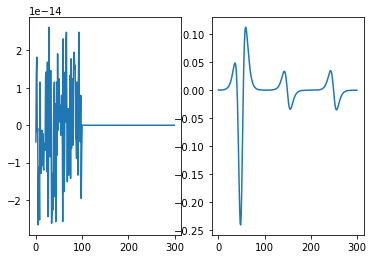

In [49]:
fig,ax = plt.subplots(ncols= 2)
ax[0].plot(np.sum(mat,axis=0))
ax[1].plot(np.dot(mat,rho_eq))

In [50]:
v,w = la.eig(mat)
for i in range(v.shape[0]):
    w[:,i] = abs(w[:,i])/sum(abs(w[:,i]))

In [55]:
v[np.argsort(v)[-1]]

(-2.2737367544323206e-13+0j)

In [52]:
#w[:,np.argsort(v)[0]] = np.real(w[:,np.argsort(v)[0]]/(w[:,np.argsort(v)[0]][0]+w[:,np.argsort(v)[0]][n]+w[:,np.argsort(v)[0]][2*n]))
rho_eq = rho_eq/sum(rho_eq)

In [53]:
print(w[:,np.argsort(v)[0]][0])

(4.1924148326244635e-06+0j)


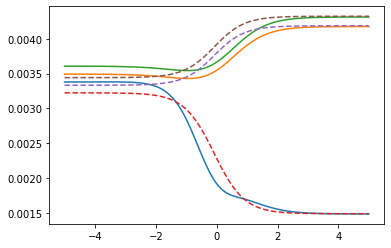

In [56]:
plt.plot(np.linspace(X0,Xf,n),np.real(w[:,np.argsort(v)[-1]][:n]))
plt.plot(np.linspace(X0,Xf,n),np.real(w[:,np.argsort(v)[-1]][n:2*n]))
plt.plot(np.linspace(X0,Xf,n),np.real(w[:,np.argsort(v)[-1]][2*n:3*n]))
plt.plot(np.linspace(X0,Xf,n),rho_eq[:n],linestyle='--')
plt.plot(np.linspace(X0,Xf,n),rho_eq[n:2*n],linestyle='--')
plt.plot(np.linspace(X0,Xf,n),rho_eq[2*n:3*n],linestyle='--')
#plt.plot(np.linspace(X0,Xf,n),V(np.linspace(X0,Xf,n))/sum(V(np.linspace(X0,Xf,n))))

In [212]:
#h = dx
h=0.001

In [259]:
from scipy.linalg import null_space
from scipy.linalg import solve
from scipy.linalg import lstsq
from copy import copy

In [260]:
W_p = null_space(mat)

ValueError: Too large work array required -- computation cannot be performed with standard 32-bit LAPACK.

In [ ]:
W_p = abs(W_p)/sum(abs(W_p))

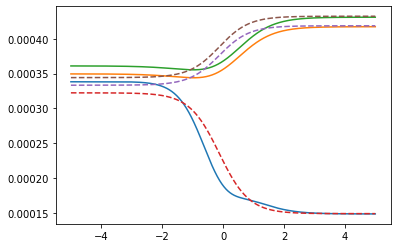

In [ ]:
plt.plot(np.linspace(X0,Xf,n),np.real(W_p[:n]))
plt.plot(np.linspace(X0,Xf,n),np.real(W_p[n:2*n]))
plt.plot(np.linspace(X0,Xf,n),np.real(W_p[2*n:3*n]))
plt.plot(np.linspace(X0,Xf,n),rho_eq[:n],linestyle='--')
plt.plot(np.linspace(X0,Xf,n),rho_eq[n:2*n],linestyle='--')
plt.plot(np.linspace(X0,Xf,n),rho_eq[2*n:3*n],linestyle='--')

In [261]:
mat_b = copy(mat)
b = mat_b[:, 0].copy()

W_pp = lstsq(mat_b[:,1:],-b)[0]

W_pp = np.r_[1,W_pp]
W_pp = abs(W_pp)/(sum(abs(W_pp)))

: 

: 

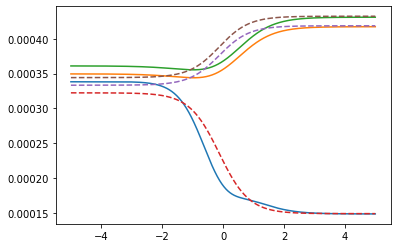

In [ ]:
plt.plot(np.linspace(X0,Xf,n),np.real(W_pp[:n]))
plt.plot(np.linspace(X0,Xf,n),np.real(W_pp[n:2*n]))
plt.plot(np.linspace(X0,Xf,n),np.real(W_pp[2*n:3*n]))
plt.plot(np.linspace(X0,Xf,n),rho_eq[:n],linestyle='--')
plt.plot(np.linspace(X0,Xf,n),rho_eq[n:2*n],linestyle='--')
plt.plot(np.linspace(X0,Xf,n),rho_eq[2*n:3*n],linestyle='--')